## Flamekit usage example 

In [1]:
import os
import sys
# Import .././ directory
module_path = os.path.abspath(os.path.join('..'))
if module_path not in sys.path:
    sys.path.append(module_path)
    
from flamekit.trainer import TorchTrainer
from flamekit.devices import select_device, print_cuda_available_devices
from flamekit.callbacks import TorchMetricsEvaluator, Callback
from flamekit.pbars import TQDMProgressBar
from flamekit.lr_scheduler import LRScheduler, CosineDecay, LinearDecay
from flamekit.sampling import split_dataset, SequentialSampler, RandomSampler
from flamekit.utils import set_up_reproducible_env, get_next_experiment_path

import torch
import torch.nn as nn
import torch.optim as optim
import torchvision
import torchvision.transforms as transforms
import torchmetrics

In [2]:
seed = 1337
checkpoints_dir = './checkpoints'

n_classes = 10
task = 'multiclass'
average = 'macro'

epochs = 15
batch_size = 128
# Learning rate
lr0 = 1e-3
lrf = lr0 * 0.1
lr_decay = 'cosine' # None, 'linear' or 'cosine'
k_decay = 2
warmup_epochs = 1
cooldown_epochs = 1

In [3]:
set_up_reproducible_env(seed=seed)
exp_path = get_next_experiment_path(checkpoints_dir)
print("Experiments Directory:", exp_path)

Experiments Directory: checkpoints\experiment_4


In [4]:
# Define the transformation to normalize the data
transform = transforms.Compose([transforms.ToTensor(), transforms.Normalize((0.5,), (0.5,))])

# Download and load the MNIST dataset
trainset = torchvision.datasets.MNIST(root='./data', train=True, download=True, transform=transform)
testset = torchvision.datasets.MNIST(root='./data', train=False, download=True, transform=transform)

train_indices, val_indices, test_indices = split_dataset(len(trainset), val_split=0.2, test_split=0)
train_sampler = RandomSampler(train_indices)
val_sampler = SequentialSampler(val_indices)

# Create data loaders
train_loader = torch.utils.data.DataLoader(trainset, batch_size=128, sampler=train_sampler)
val_loader = torch.utils.data.DataLoader(trainset, batch_size=128, sampler=val_sampler)
test_loader = torch.utils.data.DataLoader(testset, batch_size=128, shuffle=False)

print("Training Samples:", len(train_indices), "| Batches:", len(train_loader))
print("Val Samples:", len(val_indices), "| Batches:", len(val_loader))
print("Test Samples:", len(testset), "| Batches:", len(test_loader))

Training Samples: 48000 | Batches: 375
Val Samples: 12000 | Batches: 94
Test Samples: 10000 | Batches: 79


In [5]:
print_cuda_available_devices()
device = select_device(index=0, cuda=True)
print("Selected Device:", device)

Available CUDA devices:
+-------+-------------------------------------------+
| Index |                Device Name                |
+-------+-------------------------------------------+
|   0   | NVIDIA GeForce GTX 1650 with Max-Q Design |
+-------+-------------------------------------------+
Selected Device: cuda:0


In [6]:
class MLP(nn.Module):
    def __init__(self):
        super().__init__()
        self.fc1 = nn.Linear(28*28, 128)
        self.fc2 = nn.Linear(128, 64)
        self.fc3 = nn.Linear(64, 10)

    def forward(self, x):
        x = x.view(-1, 28*28)
        x = torch.relu(self.fc1(x))
        x = torch.relu(self.fc2(x))
        x = self.fc3(x)
        return x

model = MLP()
num_params = sum(p.numel() for p in model.parameters())
print(f"Number of parameters: {num_params}")

Number of parameters: 109386


In [7]:
# Instantiate the model, loss function, and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = optim.AdamW(model.parameters(), lr=lr0)

Train Model

In [8]:
trainer = TorchTrainer(model, device)
trainer.compile(optimizer, criterion)

In [9]:
supported_lr_decays = {
    "cosine": CosineDecay(k=k_decay),
    "linear": LinearDecay()
}

total_it = epochs * len(train_loader)
warmup_it = warmup_epochs * len(train_loader)      # Warmup iterations
cooldown_it = cooldown_epochs * len(train_loader)  # Cooldown iterations
lr_decay_it = total_it - cooldown_it
lr_decay_fn = supported_lr_decays[lr_decay] if lr_decay else None
    
class TrainingStrategy(Callback):
    
    def __init__(self) -> None:
        self.lr_scheduler = LRScheduler(
            lr0, lrf, lr_decay_it, warmup_it=warmup_it, decay_fn=lr_decay_fn
        )
        
    def on_fit_start(self, trainer, model):
        self.lr_scheduler.reset()
    
    def on_train_batch_start(self, trainer, model, batch, batch_idx):
        # Update lr
        new_lr = self.lr_scheduler.step()
        for param_group in trainer.optimizer.param_groups:
            param_group["lr"] = new_lr
        # Monitor lr
        trainer.log([('lr', new_lr)], average=False)

In [10]:
class MNISTEvaluator(TorchMetricsEvaluator):
    
    def calc_metrics(self, trainer, model, outputs, batch, batch_idx, stage) -> list[tuple]:
        # if stage == trainer.TRAIN: return [] # Only evaluate validation data or when in 'predict' stage
        return super().calc_metrics(trainer, model, outputs, batch, batch_idx, stage)
    
evaluator = MNISTEvaluator()

class Accuracy(torchmetrics.Accuracy):
    def update(self, preds, target):
        preds = preds.argmax(dim=1)
        super().update(preds, target)

metrics = {
    'acc': Accuracy(task=task, num_classes=n_classes, average=average),
    'precision': torchmetrics.Precision(task=task, num_classes=n_classes, average=average),
    'recall': torchmetrics.Recall(task=task, num_classes=n_classes, average=average),
    'f1': torchmetrics.F1Score(task=task, num_classes=n_classes, average=average),
    'auc': torchmetrics.AUROC(task=task, num_classes=n_classes, average=average),
}
evaluator.add_metrics(metrics)

In [11]:
strategy = TrainingStrategy()
pbar = TQDMProgressBar(show_remaining_time=False, show_rate=False)
callbacks = [strategy, evaluator, pbar]

# trainer.train_color = ... # NOTE: Can be overriden, blue by default
# trainer.val_color = ...   # NOTE: Can be overriden, orange by default

history = trainer.fit(
    train_loader,
    validation_loader=val_loader,
    epochs=epochs,
    dest_path=exp_path,
    monitor='val_loss',
    mode='min',
    prefix=model.__class__.__name__,
    save_best=True,
    callbacks=callbacks
)

Epoch 1/15: 100% |██████████████████████████████| 375/375 [01:07, lr=0.001, loss=0.886, acc=0.746, auc=0.946, f1=0.726, precision=0.751, recall=0.746, val_loss=0.335, val_acc=0.899, val_auc=0.993, val_f1=0.896, val_precision=0.906, val_recall=0.899]


[INFO] Saving best checkpoint, regarding 'val_loss' metric -- mode='min' (checkpoints\experiment_4\MLP_val-loss_0.3351_1_best.pt)


Epoch 2/15: 100% |██████████████████████████████| 375/375 [00:53, lr=0.001, loss=0.253, acc=0.923, auc=0.996, f1=0.92, precision=0.925, recall=0.923, val_loss=0.213, val_acc=0.934, val_auc=0.997, val_f1=0.932, val_precision=0.937, val_recall=0.934]


[INFO] Saving best checkpoint, regarding 'val_loss' metric -- mode='min' (checkpoints\experiment_4\MLP_val-loss_0.2127_2_best.pt)


Epoch 3/15: 100% |██████████████████████████████| 375/375 [00:55, lr=0.000999, loss=0.173, acc=0.948, auc=0.998, f1=0.946, precision=0.949, recall=0.948, val_loss=0.173, val_acc=0.945, val_auc=0.998, val_f1=0.943, val_precision=0.947, val_recall=0.945]


[INFO] Saving best checkpoint, regarding 'val_loss' metric -- mode='min' (checkpoints\experiment_4\MLP_val-loss_0.1729_3_best.pt)


Epoch 4/15: 100% |██████████████████████████████| 375/375 [00:44, lr=0.000994, loss=0.132, acc=0.959, auc=0.999, f1=0.958, precision=0.96, recall=0.959, val_loss=0.146, val_acc=0.955, val_auc=0.999, val_f1=0.954, val_precision=0.957, val_recall=0.955]


[INFO] Saving best checkpoint, regarding 'val_loss' metric -- mode='min' (checkpoints\experiment_4\MLP_val-loss_0.1458_4_best.pt)


Epoch 5/15: 100% |██████████████████████████████| 375/375 [00:50, lr=0.00098, loss=0.11, acc=0.965, auc=0.999, f1=0.964, precision=0.966, recall=0.965, val_loss=0.132, val_acc=0.958, val_auc=0.999, val_f1=0.956, val_precision=0.959, val_recall=0.958]


[INFO] Saving best checkpoint, regarding 'val_loss' metric -- mode='min' (checkpoints\experiment_4\MLP_val-loss_0.1315_5_best.pt)


Epoch 6/15: 100% |██████████████████████████████| 375/375 [00:51, lr=0.000952, loss=0.0913, acc=0.971, auc=0.999, f1=0.969, precision=0.971, recall=0.971, val_loss=0.122, val_acc=0.961, val_auc=0.999, val_f1=0.96, val_precision=0.962, val_recall=0.961] 


[INFO] Saving best checkpoint, regarding 'val_loss' metric -- mode='min' (checkpoints\experiment_4\MLP_val-loss_0.1221_6_best.pt)


Epoch 7/15: 100% |██████████████████████████████| 375/375 [00:53, lr=0.000903, loss=0.0791, acc=0.975, auc=1, f1=0.974, precision=0.975, recall=0.975, val_loss=0.103, val_acc=0.97, val_auc=0.999, val_f1=0.968, val_precision=0.969, val_recall=0.97]   


[INFO] Saving best checkpoint, regarding 'val_loss' metric -- mode='min' (checkpoints\experiment_4\MLP_val-loss_0.1033_7_best.pt)


Epoch 8/15: 100% |██████████████████████████████| 375/375 [01:20, lr=0.000826, loss=0.0657, acc=0.98, auc=1, f1=0.979, precision=0.98, recall=0.98, val_loss=0.121, val_acc=0.964, val_auc=0.999, val_f1=0.962, val_precision=0.964, val_recall=0.964]
Epoch 9/15: 100% |██████████████████████████████| 375/375 [01:02, lr=0.000718, loss=0.0593, acc=0.981, auc=1, f1=0.98, precision=0.981, recall=0.981, val_loss=0.101, val_acc=0.969, val_auc=0.999, val_f1=0.968, val_precision=0.969, val_recall=0.969] 


[INFO] Saving best checkpoint, regarding 'val_loss' metric -- mode='min' (checkpoints\experiment_4\MLP_val-loss_0.1014_9_best.pt)


Epoch 10/15: 100% |██████████████████████████████| 375/375 [01:01, lr=0.00058, loss=0.0468, acc=0.985, auc=1, f1=0.985, precision=0.986, recall=0.985, val_loss=0.0936, val_acc=0.973, val_auc=0.999, val_f1=0.972, val_precision=0.973, val_recall=0.973]


[INFO] Saving best checkpoint, regarding 'val_loss' metric -- mode='min' (checkpoints\experiment_4\MLP_val-loss_0.0936_10_best.pt)


Epoch 11/15: 100% |██████████████████████████████| 375/375 [01:00, lr=0.000423, loss=0.0385, acc=0.987, auc=1, f1=0.987, precision=0.988, recall=0.987, val_loss=0.0875, val_acc=0.973, val_auc=0.999, val_f1=0.972, val_precision=0.973, val_recall=0.973]


[INFO] Saving best checkpoint, regarding 'val_loss' metric -- mode='min' (checkpoints\experiment_4\MLP_val-loss_0.0875_11_best.pt)


Epoch 12/15: 100% |██████████████████████████████| 375/375 [01:00, lr=0.000268, loss=0.0293, acc=0.992, auc=1, f1=0.991, precision=0.992, recall=0.992, val_loss=0.0851, val_acc=0.975, val_auc=0.999, val_f1=0.974, val_precision=0.975, val_recall=0.975]


[INFO] Saving best checkpoint, regarding 'val_loss' metric -- mode='min' (checkpoints\experiment_4\MLP_val-loss_0.0851_12_best.pt)


Epoch 13/15: 100% |██████████████████████████████| 375/375 [01:00, lr=0.000148, loss=0.0242, acc=0.994, auc=1, f1=0.994, precision=0.994, recall=0.994, val_loss=0.0823, val_acc=0.977, val_auc=1, val_f1=0.976, val_precision=0.976, val_recall=0.977]    


[INFO] Saving best checkpoint, regarding 'val_loss' metric -- mode='min' (checkpoints\experiment_4\MLP_val-loss_0.0823_13_best.pt)


Epoch 14/15: 100% |██████████████████████████████| 375/375 [01:00, lr=0.0001, loss=0.0207, acc=0.995, auc=1, f1=0.995, precision=0.995, recall=0.995, val_loss=0.0841, val_acc=0.975, val_auc=1, val_f1=0.974, val_precision=0.975, val_recall=0.975]    
Epoch 15/15: 100% |██████████████████████████████| 375/375 [00:59, lr=0.0001, loss=0.0195, acc=0.996, auc=1, f1=0.996, precision=0.996, recall=0.996, val_loss=0.0837, val_acc=0.977, val_auc=1, val_f1=0.976, val_precision=0.977, val_recall=0.977]  


[END] Training finished


Plot training metrics

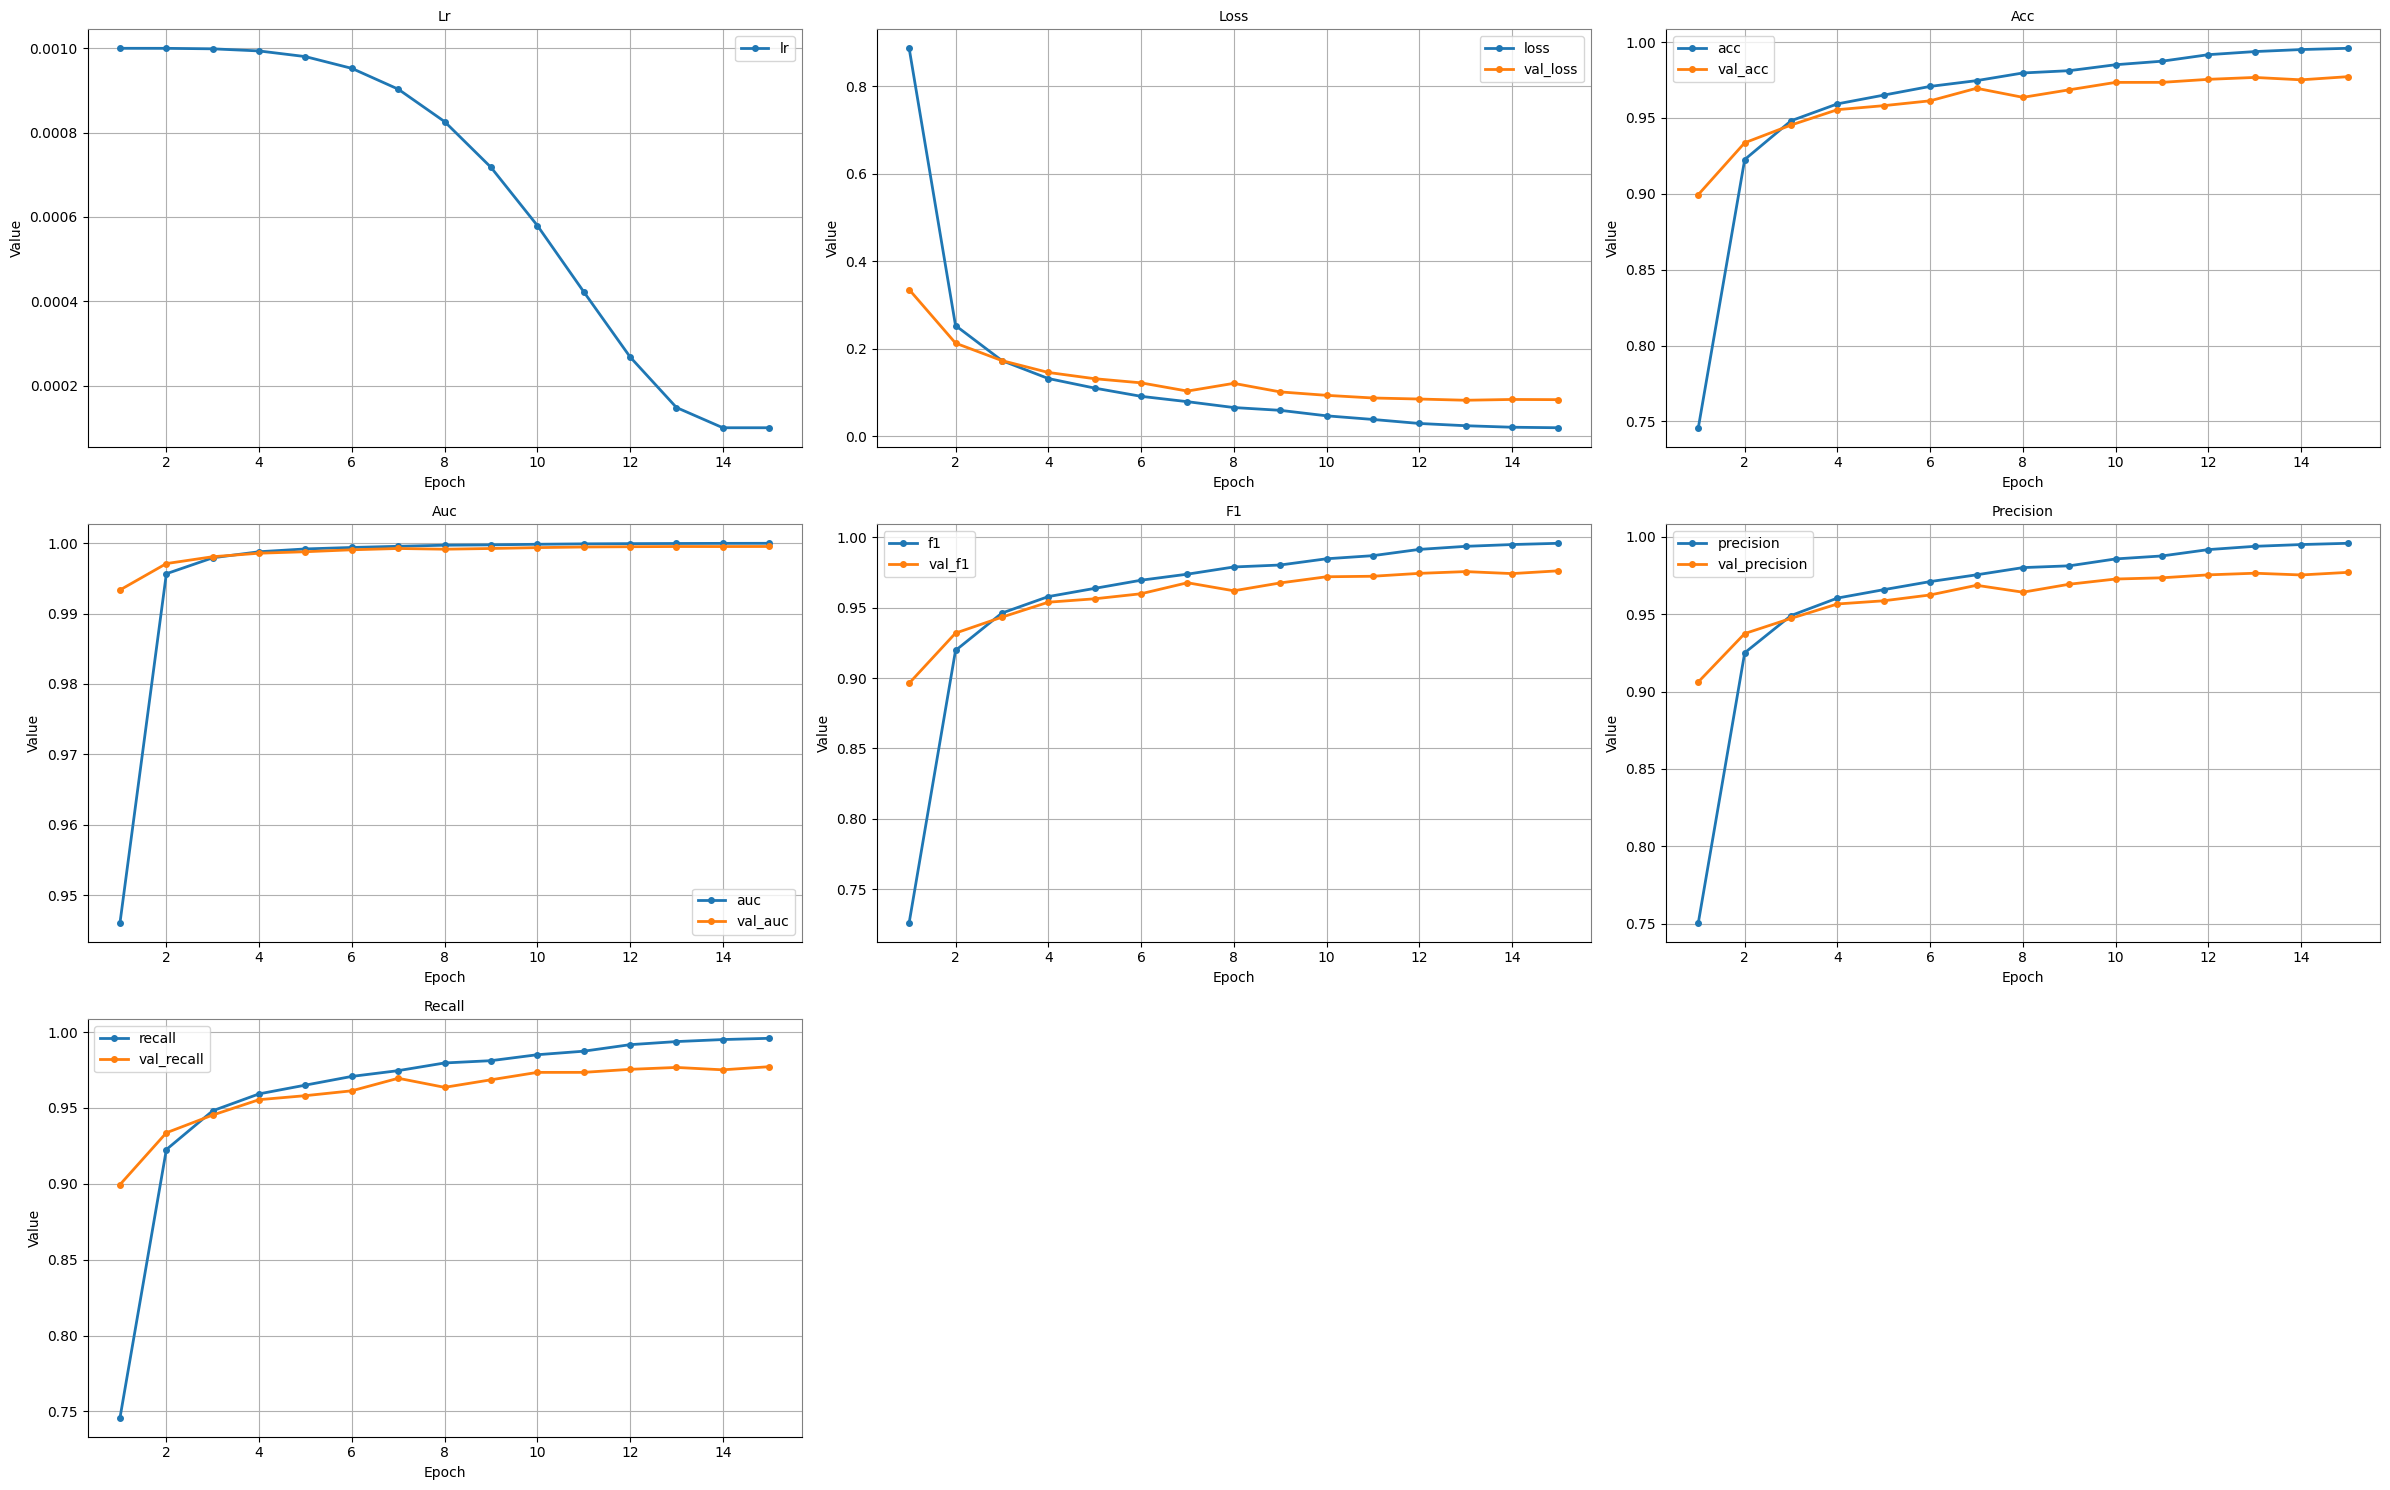

In [12]:
trainer.plot()

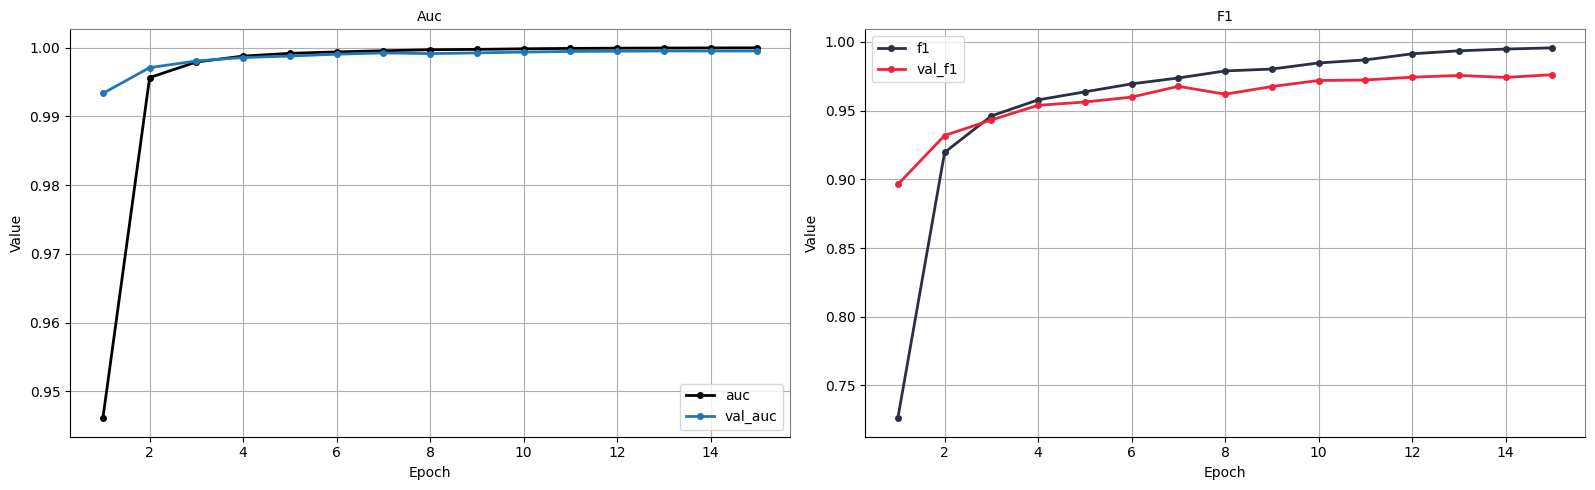

In [13]:
trainer.plot(metrics=['f1', 'auc'], colors=[['#000000', '#1f77b4'], ['#2B2F42', '#EF233C']], dest_path=exp_path/'customization_example.png')

Load best checkpoint

In [14]:
trainer.load_best()

[OK] Checkpoint 'checkpoints\experiment_4\MLP_val-loss_0.0823_13_best.pt' has been loaded successfully


Evaluate on testset

In [15]:
trainer.predict(test_loader, callbacks=callbacks)

Predicting: 100% |██████████████████████████████| 79/79 [00:09, loss=0.0743, acc=0.978, auc=1, f1=0.977, precision=0.978, recall=0.978]    
